## Organize simulations

Purpose:
This script loads all .pkl files from the `data/raw` directory, each containing simulation results (e.g., configurations and polarization curves) that we have generated so far.

For each .pkl file:
- It checks if the file contains a pandas DataFrame
- It adds a `file_source` column with the filename for traceability
- It appends it to a list of DataFrames

At the end, all valid DataFrames are concatenated into a single combined DataFrame called `combined_df`, which can be used for further processing (e.g., labeling valid/invalid polarization curves, training classifiers and running IRD analysis)

In [46]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import datetime 
from openpyxl import load_workbook
from openpyxl.worksheet.table import Table, TableStyleInfo
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import sys
sys.path.append("../external/AlphaPEM")

In [15]:
# Path to all the results from previous simulations ("raw" data)
data_path = r"..\data\raw" 

# Find all .pkl files
pkl_files = glob.glob(os.path.join(data_path, "*.pkl"))
pkl_files = pkl_files + glob.glob(os.path.join(data_path + r"\final_data_sobol_sampling", "*.pkl"))

print(pkl_files)

['..\\data\\raw\\LHS_seed42_nsamples100_ndimensions16_bounds25.pkl', '..\\data\\raw\\LHS_seed42_nsamples160_ndimensions16.pkl', '..\\data\\raw\\morris_sample_results_N10_lev4.pkl', '..\\data\\raw\\morris_sample_results_N10_lev4_corrected.pkl', '..\\data\\raw\\N10_levels4_seed42.pkl', '..\\data\\raw\\PDP_20_default.pkl', '..\\data\\raw\\PDP_20_default_updated.pkl', '..\\data\\raw\\PDP_Sc_Phi_c_des_default.pkl', '..\\data\\raw\\results.pkl', '..\\data\\raw\\sobol_1_seed42.pkl', '..\\data\\raw\\sobol_N10_seed42.pkl', '..\\data\\raw\\try_combinations_after_rev_conf2.pkl', '..\\data\\raw\\try_combinations_after_rev_conf3.pkl', '..\\data\\raw\\final_data_sobol_sampling\\results_sobol_sampling_middle_nathaly.pkl', '..\\data\\raw\\final_data_sobol_sampling\\sample_sobol_camila.pkl', '..\\data\\raw\\final_data_sobol_sampling\\sobol_dejvis.pkl']


In [16]:

all_dfs = []

for file in pkl_files:
    try:
        obj = pd.read_pickle(file)

        if isinstance(obj, pd.DataFrame):
            df = obj
        elif isinstance(obj, list) and all(isinstance(item, dict) for item in obj):
            df = pd.DataFrame(obj)
        else:
            print(f"Skipped {file}: not a DataFrame or list of dicts")
            continue

        df["file_source"] = os.path.basename(file)
        all_dfs.append(df)

    except Exception as e:
        print(f"Error reading {file}: {e}")

In [17]:
# Concatenate all loaded data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df = combined_df.dropna(axis = 0, how = "any")
    print("Loaded and combined", len(all_dfs), "files.")
    print("Shape:", combined_df.shape)
    print("Columns:", combined_df.columns.tolist())
else:
    print("No valid dfs loaded.")

combined_df["file_source"] = combined_df["file_source"].astype("str")

Loaded and combined 16 files.
Shape: (18391, 49)
Columns: ['Tfc', 'Pa_des', 'Sc', 'Phi_c_des', 'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c', 'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c', 'a_slim', 'b_slim', 'a_switch', 'Pc_des', 't_step', 'i_step', 'delta_pola', 'i_EIS', 'ratio_EIS', 'f_EIS', 't_EIS', 'current_density', 'max_step', 'n_gdl', 't_purge', 'type_fuel_cell', 'type_current', 'type_auxiliary', 'type_control', 'type_purge', 'type_display', 'type_plot', 'C_scl', 'i_max_pola', 'Aact', 'Hgdl', 'Hmem', 'Hcl', 'Hgc', 'Wgc', 'Lgc', 'Sa', 'Phi_a_des', 'ifc', 'Ucell', 'file_source']


In [18]:
object_cols = combined_df.select_dtypes(include='object').columns.tolist()
print("Object columns:")
print(object_cols)

Object columns:
['t_step', 'i_step', 'delta_pola', 'f_EIS', 't_EIS', 'current_density', 't_purge', 'type_fuel_cell', 'type_current', 'type_auxiliary', 'type_control', 'type_purge', 'type_display', 'type_plot', 'ifc', 'Ucell', 'file_source']


In [19]:
combined_df = combined_df.reset_index(drop=True)
combined_df["id"] = combined_df.index   # Add an id column to identify each simulation
col = combined_df.pop('id') 
combined_df.insert(0, 'id', col)
combined_df.head()

,id,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,...,Hmem,Hcl,Hgc,Wgc,Lgc,Sa,Phi_a_des,ifc,Ucell,file_source
0,0,350.733907,254576.953326,1.965843,0.526908,0.654882,2.200366,0.237799,0.261160,4.0,...,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,"[0.0008164730166986323, 0.100815105980188, 0.2...","[5.172468388658444, 5.06784254392706, 4.973617...",LHS_seed42_nsamples100_ndimensions16_bounds25.pkl
1,1,345.666812,191995.755332,2.194138,0.542105,0.682802,2.059682,0.230037,0.218330,3.0,...,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,"[0.0008250933331274691, 0.10082374069636248, 0...","[3.2903623816128293, 3.1716723193134513, 3.086...",LHS_seed42_nsamples100_ndimensions16_bounds25.pkl
2,2,343.601126,212985.109250,2.397039,0.252432,0.643588,1.862864,0.315966,0.228248,3.0,...,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,"[0.000823401325184997, 0.10082204588579924, 0....","[5.988973682867604, 5.844336054761755, 5.73757...",LHS_seed42_nsamples100_ndimensions16_bounds25.pkl
3,3,342.947626,245481.210389,1.915101,0.279978,0.645266,3.120027,0.246619,0.225164,5.0,...,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,"[0.0008132342251399027, 0.10081186169951903, 0...","[3.8766153136117563, 3.68344490203602, 3.54680...",LHS_seed42_nsamples100_ndimensions16_bounds25.pkl
4,4,354.654792,228129.457509,2.082688,0.405088,0.633711,2.793449,0.317232,0.236694,4.0,...,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,"[0.0008149076089063957, 0.10081353792478748, 0...","[5.610535323434828, 5.453559336069471, 5.32368...",LHS_seed42_nsamples100_ndimensions16_bounds25.pkl


### Explore the samples

Here I want to take all the combined simulation data and organizing it into two separate tables:

- One table (`polarization_df`) contains the polarization curves. We want to unpack the `ifc` and `Ucell` vectors into one column per value, and kept the `id` for reference
- Another table (`config_df`) contains all the configuration parameters used in the simulations, plus the `file_source`, so I know where each run came from

In [20]:
exclude_cols = ["ifc", "Ucell"]
config_columns = [col for col in combined_df.columns if col not in exclude_cols]
config_df = combined_df[config_columns].copy()
config_df.head()

,id,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,...,Aact,Hgdl,Hmem,Hcl,Hgc,Wgc,Lgc,Sa,Phi_a_des,file_source
0,0,350.733907,254576.953326,1.965843,0.526908,0.654882,2.200366,0.237799,0.261160,4.0,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,LHS_seed42_nsamples100_ndimensions16_bounds25.pkl
1,1,345.666812,191995.755332,2.194138,0.542105,0.682802,2.059682,0.230037,0.218330,3.0,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,LHS_seed42_nsamples100_ndimensions16_bounds25.pkl
2,2,343.601126,212985.109250,2.397039,0.252432,0.643588,1.862864,0.315966,0.228248,3.0,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,LHS_seed42_nsamples100_ndimensions16_bounds25.pkl
3,3,342.947626,245481.210389,1.915101,0.279978,0.645266,3.120027,0.246619,0.225164,5.0,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,LHS_seed42_nsamples100_ndimensions16_bounds25.pkl
4,4,354.654792,228129.457509,2.082688,0.405088,0.633711,2.793449,0.317232,0.236694,4.0,...,0.0085,0.0002,0.00002,0.00001,0.0005,0.00045,9.67,1.3,0.5,LHS_seed42_nsamples100_ndimensions16_bounds25.pkl


In [21]:
curves_df = combined_df[["id", "ifc", "Ucell"]].copy()

# Expand 'ifc'
ifc_expanded = pd.DataFrame(curves_df["ifc"].to_list(), index=curves_df["id"])
ifc_expanded.columns = [f"ifc_{i}" for i in ifc_expanded.columns]

# Expand 'Ucell'
ucell_expanded = pd.DataFrame(curves_df["Ucell"].to_list(), index=curves_df["id"])
ucell_expanded.columns = [f"Ucell_{i}" for i in ucell_expanded.columns]

# Combine into one polarization curve DataFrame
polarization_df = pd.concat([curves_df["id"], ifc_expanded, ucell_expanded], axis=1)
polarization_df.head()

,id,ifc_0,ifc_1,ifc_2,ifc_3,ifc_4,ifc_5,ifc_6,ifc_7,ifc_8,...,Ucell_21,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30
0,0,0.000816,0.100815,0.200815,0.300815,0.400815,0.500815,0.600815,0.700815,0.800815,...,3.192635,3.086450,2.978005,2.867151,2.753730,2.637573,2.518497,2.396302,2.270773,2.141674
1,1,0.000825,0.100824,0.200824,0.300824,0.400824,0.500824,0.600824,0.700824,0.800824,...,2.010969,1.956061,1.900849,1.845296,1.789370,1.733027,1.676231,1.618943,1.561127,1.502744
2,2,0.000823,0.100822,0.200822,0.300822,0.400822,0.500822,0.600822,0.700822,0.800822,...,4.138180,4.047590,3.955434,3.861625,3.766075,3.668693,3.569389,3.468068,3.364631,3.258973
3,3,0.000813,0.100812,0.200812,0.300812,0.400812,0.500812,0.600812,0.700812,0.800812,...,1.412006,1.293637,1.173566,1.051647,0.927700,0.801499,0.672823,0.541436,0.407077,0.269462
4,4,0.000815,0.100814,0.200814,0.300814,0.400814,0.500814,0.600814,0.700814,0.800814,...,3.321548,3.178508,3.032086,2.885685,2.742082,2.599100,2.454325,2.306605,2.155249,1.999713


#### Filter out duplicate simulation configurations

I'm defining the (variable) input parameters, keeping only one row per unique configuration (even if it was simulated multiple times). Then I filter the polarization curves to match only these unique configs


In [32]:
# Operating conditions
ls_operating_conditions = [
    "Tfc", "Pa_des", "Pc_des", "Sa", "Sc", "Phi_a_des", "Phi_c_des"
]

# Undetermined physical parameters
ls_undetermined_physical_parameters = [
    "epsilon_gdl", "tau", "epsilon_mc", "epsilon_c", "e", "Re", "i0_c_ref",
    "kappa_co", "kappa_c", "a_slim", "b_slim", "a_switch"
]

desired_columns = ["id"] + ls_operating_conditions + ls_undetermined_physical_parameters

config_var_df = config_df[desired_columns].copy()
print("Number of simulations before filtering duplicates:", len(config_var_df))

# Drop duplicates based on configuration values only
config_var_df = config_var_df.drop_duplicates(subset = ls_operating_conditions + ls_undetermined_physical_parameters)

# Filter polarization_df accordingly
polarization_df = polarization_df[polarization_df["id"].isin(config_var_df["id"])]

print("Remaining polarization curves:", len(polarization_df))

Number of simulations before filtering duplicates: 18391
Remaining polarization curves: 16873


#### Check fixed parameters

These object-type columns aren't part of the input parameters and should be fixed across all simulations. I'm printing how many unique values each has to confirm that

In [33]:
selected_columns = ls_operating_conditions + ls_undetermined_physical_parameters

object_cols = config_df.select_dtypes(include='object').columns
other_object_cols = [col for col in object_cols if col not in selected_columns]

for col in other_object_cols:
    try:
        unique_vals = config_df[col].apply(lambda x: str(x)).unique()
        print(f"{col} ({len(unique_vals)} unique values): {unique_vals}")
    except Exception as e:
        print(f"Error in column '{col}': {e}")

t_step (1 unique values): ['(0, 1000, 50, 10)']
i_step (1 unique values): ['(5000.0, 15000.0)']
delta_pola (1 unique values): ['(30, 30, 1000.0, 60)']
f_EIS (1 unique values): ['(-3, 5, 90, 50)']
t_EIS (1 unique values): ['(np.float64(1000.0), array([  1000.        , 101000.        , 182304.08367888, 248407.6239075 ,\n       302152.50156968, 345849.28187725, 381376.5487035 , 410261.66745272,\n       433746.44857134, 452840.53466382, 468364.80639817, 480986.6732796 ,\n       491248.76649071, 499592.26734228, 506375.87425639, 511891.22369829,\n       516375.4280237 , 520021.26926077, 522985.48707096, 525395.51719978,\n       527354.9701124 , 528948.08534813, 530243.35309248, 531296.45866322,\n       532152.67649768, 532848.81656228, 533414.80686292, 533874.98009058,\n       534249.11971665, 534553.31051131, 534800.63004955, 535001.71093387,\n       535165.19790432, 535298.11948758, 535406.19016286, 535494.05603512,\n       535565.49457743, 535623.57702965, 535670.80043521, 535709.1949923

#### Coefficient of Variation for `ifc_` columns

Since the `ifc` values represent the same current density grid across all simulations, the coef. of variation values should ideally be very small




In [34]:
ifc_columns = [col for col in polarization_df.columns if col.startswith("ifc_")]

cv_series = (polarization_df[ifc_columns].std() / polarization_df[ifc_columns].mean())
cv_df = cv_series.to_frame().T
cv_df.index = ['coef_variation'] 

cv_df

,ifc_0,ifc_1,ifc_2,ifc_3,ifc_4,ifc_5,ifc_6,ifc_7,ifc_8,ifc_9,...,ifc_21,ifc_22,ifc_23,ifc_24,ifc_25,ifc_26,ifc_27,ifc_28,ifc_29,ifc_30
coef_variation,0.015344,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,...,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,0.013336,0.013338,0.013349


In [35]:
def plot_polarization_curve(row):

    ucell_cols = [col for col in row.index if col.startswith("Ucell_")]
    ifc_cols = [col for col in row.index if col.startswith("ifc_")]
    
    # Extract voltages and current densities
    voltages = row[ucell_cols].values.astype(float)
    current_densities = row[ifc_cols].values.astype(float)

    plt.figure(figsize=(8, 5))
    plt.plot(current_densities, voltages, marker='o', label=f"ID: {row.name}")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Reference line at 0 voltage (for zero-crossing)

    plt.title("Polarization Curve")
    plt.xlabel(r"Current density $i_{fc}$ (A.cm$^{-2}$)")
    plt.ylabel(r"Cell voltage $U_{cell}$ (V)")

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Classification of polarization curves: Validity criteria

This code adds three checks to identify valid polarization curves: the first value should be between 0–1.23V, the next 4 also in range, and the curve must decrease monotonically

In [25]:
ucell_cols = [col for col in polarization_df.columns if col.startswith("Ucell_")]

# Condition 1: First value in range
polarization_df["start_in_range"] = polarization_df[ucell_cols[0]].between(0, 1.23)

# Condition 2: First x values in range
tolerance = 3  # Number of steps in the current density
polarization_df["early_values_in_range"] = polarization_df[ucell_cols[:tolerance]].apply(
    lambda row: row.between(0, 1.23).all(), axis=1
)

# Condition 3: Monotonic decreasing
polarization_df["monotonic"] = polarization_df[ucell_cols].apply(
    lambda row: all(x >= y for x, y in zip(row, row[1:])), axis=1
)

# Condition 4
minimum_voltage_allowed = -5
polarization_df["minimum_voltage"] = polarization_df[ucell_cols[-1]] > minimum_voltage_allowed

conditions_cols = ["start_in_range", "early_values_in_range", "monotonic", "minimum_voltage"]

# Final classification
polarization_df["classification"] = polarization_df[conditions_cols].all(axis=1)
polarization_df["classification"] = polarization_df["classification"].map({True: "valid", False: "invalid"})

polarization_df[ucell_cols + conditions_cols].head()

,Ucell_0,Ucell_1,Ucell_2,Ucell_3,Ucell_4,Ucell_5,Ucell_6,Ucell_7,Ucell_8,Ucell_9,...,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,start_in_range,early_values_in_range,monotonic,minimum_voltage
0,5.172468,5.067843,4.973617,4.880443,4.780709,4.685927,4.597707,4.510062,4.422338,4.334267,...,2.753730,2.637573,2.518497,2.396302,2.270773,2.141674,False,False,True,True
1,3.290362,3.171672,3.086977,3.018571,2.954977,2.893277,2.833025,2.775430,2.718885,2.663087,...,1.789370,1.733027,1.676231,1.618943,1.561127,1.502744,False,False,True,True
2,5.988974,5.844336,5.737573,5.644948,5.558558,5.475831,5.395550,5.316980,5.239680,5.167109,...,3.766075,3.668693,3.569389,3.468068,3.364631,3.258973,False,False,True,True
3,3.876615,3.683445,3.546809,3.432739,3.322250,3.211352,3.093756,2.976949,2.865941,2.755700,...,0.927700,0.801499,0.672823,0.541436,0.407077,0.269462,False,False,True,True
4,5.610535,5.453559,5.323688,5.205455,5.094028,4.987335,4.884190,4.783810,4.685626,4.589196,...,2.742082,2.599100,2.454325,2.306605,2.155249,1.999713,False,False,True,True


In [36]:
check_cols = conditions_cols + ["classification"]
polarization_df["classification_bool"] = polarization_df["classification"] == "valid"

summary = pd.DataFrame()

for col in check_cols[:-1]:
    counts = polarization_df[col].value_counts().reindex([True, False], fill_value=0)
    total = counts.sum()
    summary[col] = [f"{counts[True]} ({counts[True]/total:.1%})", f"{counts[False]} ({counts[False]/total:.1%})"]

classification_counts = polarization_df["classification"].value_counts()
total = classification_counts.sum()
summary["valid PC"] = [
    f"{classification_counts.get('valid', 0)} ({classification_counts.get('valid', 0)/total:.1%})",
    f"{classification_counts.get('invalid', 0)} ({classification_counts.get('invalid', 0)/total:.1%})"
]

polarization_df = polarization_df.drop(columns = ["classification_bool"])

summary.index = ["True", "False"]
summary

,start_in_range,early_values_in_range,monotonic,minimum_voltage,valid PC
True,1909 (11.3%),1739 (10.3%),15966 (94.6%),15796 (93.6%),1589 (9.4%)
False,14964 (88.7%),15134 (89.7%),907 (5.4%),1077 (6.4%),15284 (90.6%)


#### Final configurations dataset + conditions for validity

In [37]:
config_var_df = pd.merge(config_var_df, polarization_df[["id"] + check_cols], on="id", how="left")
print(len(config_var_df))
config_var_df.head()

16873


,id,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,...,kappa_co,kappa_c,a_slim,b_slim,a_switch,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
0,0,350.733907,254576.953326,252576.953326,1.3,1.965843,0.5,0.526908,0.654882,2.200366,...,23.018893,56.178067,0.500886,0.362783,0.498864,False,False,True,True,invalid
1,1,345.666812,191995.755332,189995.755332,1.3,2.194138,0.5,0.542105,0.682802,2.059682,...,22.595591,36.922855,0.411585,0.611276,0.720162,False,False,True,True,invalid
2,2,343.601126,212985.109250,210985.109250,1.3,2.397039,0.5,0.252432,0.643588,1.862864,...,20.742342,69.083870,0.380976,0.373063,0.608558,False,False,True,True,invalid
3,3,342.947626,245481.210389,243481.210389,1.3,1.915101,0.5,0.279978,0.645266,3.120027,...,18.782400,38.165799,0.422645,0.557174,0.431175,False,False,True,True,invalid
4,4,354.654792,228129.457509,226129.457509,1.3,2.082688,0.5,0.405088,0.633711,2.793449,...,19.948737,66.353203,0.251690,0.702215,0.341081,False,False,True,True,invalid


Check that the pressure of the anode should be more than the pressure of the cathode -> we basically want to assert that Pa_des >= Pc_des

In [38]:
# Filter: Pa_des <= Pc_des
filtered_df = config_var_df[config_var_df["Pa_des"] <= config_var_df["Pc_des"]]

# Print value counts for 'classification'
filtered_df["classification"].value_counts()

classification
valid      999
invalid     36
Name: count, dtype: int64

In [39]:
# Save only those samples that respect this:
config_var_df = config_var_df[config_var_df["Pa_des"] >= config_var_df["Pc_des"]].copy()
print(len(config_var_df))

16200


In [40]:
config_var_df.head()

,id,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,...,kappa_co,kappa_c,a_slim,b_slim,a_switch,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
0,0,350.733907,254576.953326,252576.953326,1.3,1.965843,0.5,0.526908,0.654882,2.200366,...,23.018893,56.178067,0.500886,0.362783,0.498864,False,False,True,True,invalid
1,1,345.666812,191995.755332,189995.755332,1.3,2.194138,0.5,0.542105,0.682802,2.059682,...,22.595591,36.922855,0.411585,0.611276,0.720162,False,False,True,True,invalid
2,2,343.601126,212985.109250,210985.109250,1.3,2.397039,0.5,0.252432,0.643588,1.862864,...,20.742342,69.083870,0.380976,0.373063,0.608558,False,False,True,True,invalid
3,3,342.947626,245481.210389,243481.210389,1.3,1.915101,0.5,0.279978,0.645266,3.120027,...,18.782400,38.165799,0.422645,0.557174,0.431175,False,False,True,True,invalid
4,4,354.654792,228129.457509,226129.457509,1.3,2.082688,0.5,0.405088,0.633711,2.793449,...,19.948737,66.353203,0.251690,0.702215,0.341081,False,False,True,True,invalid


There doesn't seem to be a pattern. I conclude that Pa_des <= Pc_des did not necessarily cause the polarization curve to be wrong. 

#### Merge complete dataset with all columns

In [41]:
complete_df = pd.merge(config_var_df.drop(columns = check_cols), polarization_df, on = "id")
complete_df = complete_df.set_index("id")
complete_df.head()

,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,...,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
id,,,,,,,,,,,,,,,,,,,,,
0,350.733907,254576.953326,252576.953326,1.3,1.965843,0.5,0.526908,0.654882,2.200366,0.237799,...,2.637573,2.518497,2.396302,2.270773,2.141674,False,False,True,True,invalid
1,345.666812,191995.755332,189995.755332,1.3,2.194138,0.5,0.542105,0.682802,2.059682,0.230037,...,1.733027,1.676231,1.618943,1.561127,1.502744,False,False,True,True,invalid
2,343.601126,212985.109250,210985.109250,1.3,2.397039,0.5,0.252432,0.643588,1.862864,0.315966,...,3.668693,3.569389,3.468068,3.364631,3.258973,False,False,True,True,invalid
3,342.947626,245481.210389,243481.210389,1.3,1.915101,0.5,0.279978,0.645266,3.120027,0.246619,...,0.801499,0.672823,0.541436,0.407077,0.269462,False,False,True,True,invalid
4,354.654792,228129.457509,226129.457509,1.3,2.082688,0.5,0.405088,0.633711,2.793449,0.317232,...,2.599100,2.454325,2.306605,2.155249,1.999713,False,False,True,True,invalid


#### Save the samples for the IRD exercise

First, I filter out all rows from `complete_df` where the classification is `"valid"`. These are the configurations that work and I want to keep all of them as they are.

In [51]:
# Select all valid configurations
df_valid = complete_df[complete_df["classification"] == "valid"].copy()
print("Number of valid configs:", len(df_valid))

Number of valid configs: 930


Next, I would like to focus on the remaining configurations (those that are invalid). From this set, I want to select about 1000 samples (to keep it balanced with valid PCs), but not just randomly. My objective would be to choose samples that cover the full range of important variables (`ls_operating_conditions` and `ls_undetermined_physical_parameters`) as broadly as possible. For example, for a variable like temperature, I want the selected points to span low to high values (and I want the same for all the other variables too)

The idea to achieve this is to apply k-means clustering with 1000 clusters to group similar configurations based on those variables. From each cluster, I select one representative configuration, the one closest to the cluster center. This gives me a set of 1000 configurations that are well distributed across the input space.

Finally, I combine this diverse set of configurations with the valid ones to create a single dataset that includes both the reliable points and and the "unphysical" ones, so we can do the IRD analysis.

In [53]:
all_range_vars = ls_operating_conditions + ls_undetermined_physical_parameters

df_other = complete_df[complete_df["classification"] != "valid"].copy()   #  Remaining configurations 
df_other = df_other.dropna(subset=all_range_vars)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_other[all_range_vars])

# Use KMeans clustering to pick ~1500 representative samples
n_samples = 1000
kmeans = KMeans(n_clusters=n_samples, random_state=42)
kmeans.fit(X_scaled)

# Find the nearest sample to each cluster center
df_other["cluster"] = kmeans.labels_
representative_idxs = df_other.groupby("cluster").apply(lambda x: x.sample(1, random_state=42)).index.get_level_values(1)
df_sampled = df_other.loc[representative_idxs].drop(columns=["cluster"])

# Final result
df_combined = pd.concat([df_valid, df_sampled], ignore_index=True)

print(f"Selected {len(df_valid)} valid samples and {len(df_sampled)} diverse invalid samples.")


Selected 930 valid samples and 1000 diverse invalid samples.


C:\Users\User\AppData\Local\Temp\ipykernel_18964\1600664829.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  representative_idxs = df_other.groupby("cluster").apply(lambda x: x.sample(1, random_state=42)).index.get_level_values(1)


In [54]:
df_combined.head()

,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,...,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
0,344.500610,149006.296885,147006.296885,1.3,2.063864,0.5,0.523088,0.564964,3.464645,0.353905,...,0.031121,-0.002316,-0.035761,-0.069267,-0.102894,True,True,True,True,valid
1,348.081296,210164.669104,208164.669104,1.3,1.398912,0.5,0.292336,0.784333,1.186575,0.338122,...,0.708297,0.698507,0.688787,0.679129,0.669525,True,True,True,True,valid
2,362.589621,139780.216165,137780.216165,1.3,1.670468,0.5,0.386043,0.611066,2.144047,0.304137,...,0.068309,0.039748,0.011274,-0.017161,-0.045606,True,True,True,True,valid
3,359.486693,202173.684671,200173.684671,1.3,1.224503,0.5,0.544444,0.567310,1.871998,0.236768,...,0.441349,0.417958,0.393777,0.368563,0.341975,True,True,True,True,valid
4,355.154473,168838.303488,166838.303488,1.3,1.171810,0.5,0.281310,0.599819,3.195903,0.313298,...,-0.308253,-0.349748,-0.393445,-0.438864,-0.485706,True,True,True,True,valid


In [58]:
date_today = datetime.today().strftime('%d%m%y')
data_path = '../data/raw/complete_data/'

file_path =  data_path + 'samples_for_IRD_' + date_today + '.csv'
df_combined.to_csv(file_path, index=True)
print(f"Saved CSV to: {file_path}")

df_for_classification = df_combined[ls_operating_conditions + ls_undetermined_physical_parameters + ["classification"]]
path_classification = data_path + 'data_for_classification_up_until_' + date_today+ '.csv'
df_for_classification.to_csv(path_classification, index = True)

Saved CSV to: ../data/raw/complete_data/samples_for_IRD_110625.csv


In [59]:
df_for_classification["classification"].value_counts()

classification
invalid    1000
valid       930
Name: count, dtype: int64

#### Examples of invalid polarization curves

In [78]:
ifc_cols = [col for col in polarization_df.columns if col.startswith("ifc_")]
ucell_cols = [col for col in polarization_df.columns if col.startswith("Ucell_")]

In [79]:
complete_df[(complete_df["start_in_range"] == False) &
                 (complete_df["Ucell_0"] < 0)]

,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,...,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,start_in_range,early_values_in_range,monotonic,minimum_voltage,classification
id,,,,,,,,,,,,,,,,,,,,,


In [85]:
# Use a fixed random seed for reproducibility (optional)
RANDOM_SEED = 42

""" # Scenario 1: Starts out of range and below 0
s1 = complete_df[(complete_df["start_in_range"] == False) &
                 (complete_df["Ucell_0"] < 0)].sample(n=3, random_state=RANDOM_SEED)
s1["failure_case"] = "Start < 0V"
 """
# Scenario 2: Starts out of range and above 1.23 V
s2 = complete_df[(complete_df["start_in_range"] == False) &
                 (complete_df["Ucell_0"] > 1.23) &
                 (complete_df["monotonic"] == True)].sample(n=3, random_state=RANDOM_SEED)
s2["failure_case"] = "Start > 1.23V"

# Scenario 3: Not monotonic
s3 = complete_df[(complete_df["monotonic"] == False)].sample(n=3, random_state=RANDOM_SEED)
s3["failure_case"] = "Not monotonic"

""" # Scenario 4: Start in range, but early values out of range
s4 = complete_df[(complete_df["start_in_range"] == True) &
                 (complete_df["early_values_in_range"] == False) &
                 (complete_df["monotonic"] == True)].sample(n=3, random_state=RANDOM_SEED)
s4["failure_case"] = "Early values out of range" """


' # Scenario 4: Start in range, but early values out of range\ns4 = complete_df[(complete_df["start_in_range"] == True) &\n                 (complete_df["early_values_in_range"] == False) &\n                 (complete_df["monotonic"] == True)].sample(n=3, random_state=RANDOM_SEED)\ns4["failure_case"] = "Early values out of range" '

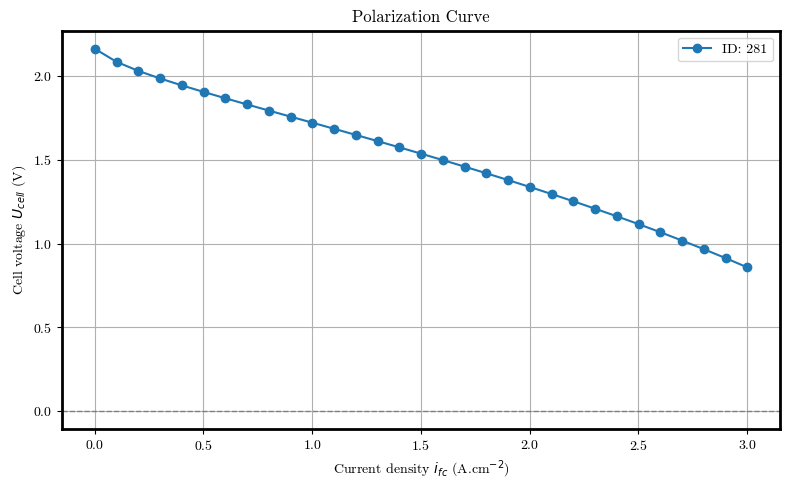

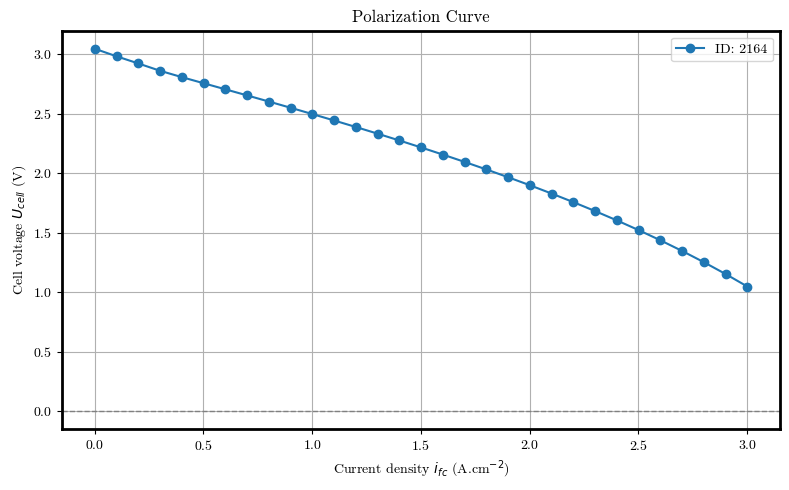

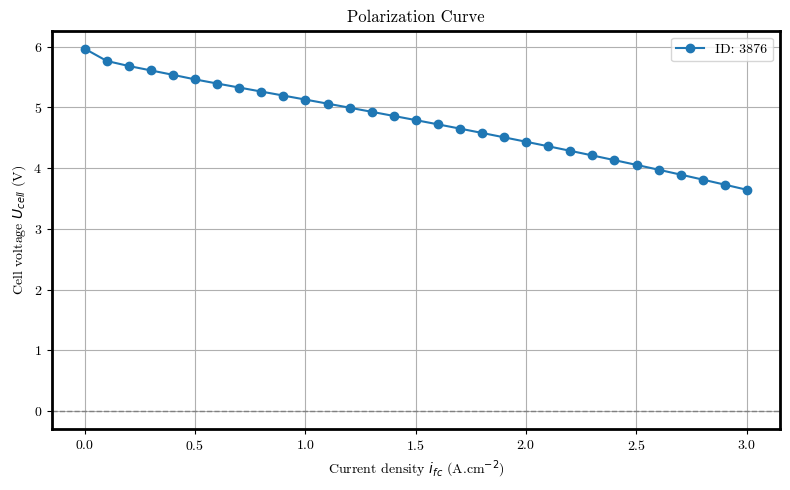

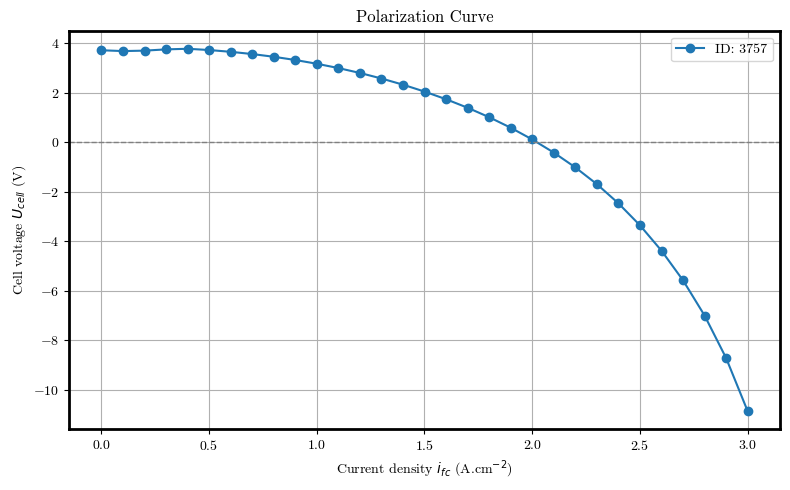

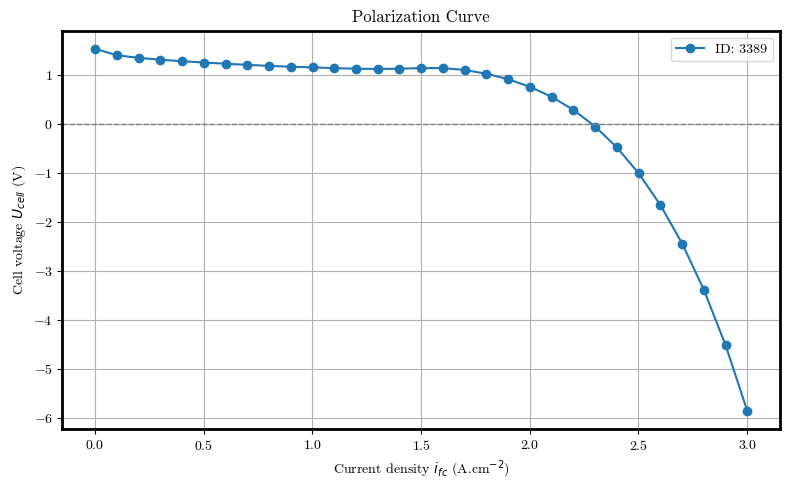

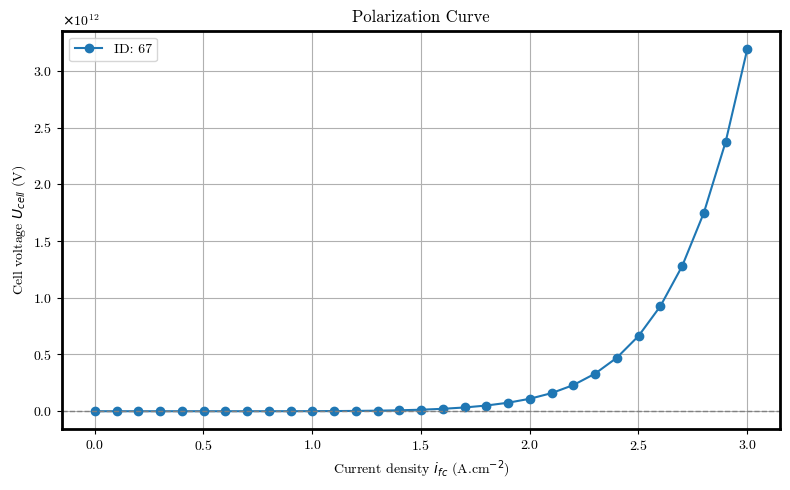

In [86]:
# Combine all examples
selected_examples_df = pd.concat([s2,
                                  # s1, s4
                                   s3,], ignore_index=False)

# Plot all selected examples
for _, row in selected_examples_df.iterrows():
    plot_polarization_curve(row)

In [87]:
selected_examples_df['failure_case']

id
281     Start > 1.23V
2164    Start > 1.23V
3876    Start > 1.23V
3757    Not monotonic
3389    Not monotonic
67      Not monotonic
Name: failure_case, dtype: object

In [117]:
def export_simulation_dataframe_to_excel(
    df,
    save_dir="../results",
    base_filename="simulation_export"
):

    df_all = df.reset_index()

    # Subsets
    dfs = {
        "classification": df_all[["id", "start_in_range", "early_values_in_range", "monotonic", "minimum_voltage", "classification"]],
        "operating_params": df_all[["id"] + ls_operating_conditions],
        "undetermined_physical_params": df_all[["id"] + ls_undetermined_physical_parameters],
        "current_densities_from_pc": df_all[["id"] + ifc_cols],
        "voltages_from_pc": df_all[["id"] + ucell_cols],
    }

    # Ensure directory exists
    os.makedirs(save_dir, exist_ok=True)

    # File path
    date_str = datetime.today().strftime("%Y%m%d")
    file_path = os.path.join(save_dir, f"{base_filename}_{date_str}.xlsx")

    # Save all sheets
    with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
        for sheet_name, subset_df in dfs.items():
            subset_df.to_excel(writer, sheet_name=sheet_name, index=False)

    wb = load_workbook(file_path)
    for sheet_name, subset_df in dfs.items():
        ws = wb[sheet_name]
        n_rows, n_cols = subset_df.shape
        col_end = chr(64 + n_cols) if n_cols <= 26 else chr(64 + (n_cols - 1) // 26) + chr(65 + (n_cols - 1) % 26)
        table_range = f"A1:{col_end}{n_rows + 1}"
        table = Table(displayName=sheet_name.replace(" ", "_"), ref=table_range)
        table.tableStyleInfo = TableStyleInfo(name="TableStyleMedium9", showRowStripes=True)
        ws.add_table(table)

    wb.save(file_path)
    print(f"Excel file with formatted tables saved to: {file_path}")


In [119]:
export_simulation_dataframe_to_excel(
    selected_examples_df,
    save_dir="../results/faulty_pc",
    base_filename="failing_polarization_examples"
)

Excel file with formatted tables saved to: ../results/faulty_pc\failing_polarization_examples_20250605.xlsx


In [107]:

columns_to_keep = ls_operating_conditions + ls_undetermined_physical_parameters + ['failure_case']
example_metadata_df = selected_examples_df[columns_to_keep].copy()
#example_metadata_df.reset_index(drop=True, inplace=True)
example_metadata_df.head()


,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,i0_c_ref,kappa_co,kappa_c,a_slim,b_slim,a_switch,failure_case
323,343.0,300000.000000,263333.333467,3.000000,4.066667,1.0,0.4,0.716667,4.0,0.233333,0.25,4.0,0.000003,0.001000,40.00,1.000000e-08,6.666667e-01,6.666667e-01,1.000000e-08,Start < 0V
373,343.0,110000.000000,101325.000000,1.100000,4.066667,0.1,1.0,0.550000,2.0,0.316667,0.30,5.0,0.000005,166.667333,13.34,1.000000e-08,1.000000e-08,1.000000e-08,3.333333e-01,Start < 0V
435,333.0,110000.000000,101325.000000,3.000000,4.066667,0.1,1.0,0.716667,4.0,0.150000,0.30,3.0,0.000003,0.001000,13.34,1.000000e-08,1.000000e-08,1.000000e+00,1.000000e+00,Start < 0V
301,353.0,236666.666667,200000.000133,3.000000,4.066667,1.0,0.1,0.716667,1.0,0.316667,0.25,3.0,0.000002,0.001000,26.67,6.666667e+01,1.000000e+00,6.666667e-01,1.000000e-08,Start > 1.23V
306,333.0,110000.000000,101325.000000,1.733333,4.066667,0.4,0.7,0.716667,1.0,0.316667,0.25,3.0,0.000002,0.001000,26.67,6.666667e+01,1.000000e+00,6.666667e-01,1.000000e-08,Start > 1.23V


## Save the results

In [121]:
export_simulation_dataframe_to_excel(
    complete_df,
    save_dir="../results",
    base_filename="complete_simulation_data"
)

Excel file with formatted tables saved to: ../results\complete_simulation_data_20250605.xlsx


In [39]:
date_today = datetime.today().strftime('%d%m%y')
data_path = '../data/raw/complete_data/'

file_path =  data_path + 'complete_samples_up_until_' + date_today + '.csv'
complete_df.to_csv(file_path, index=True)
print(f"Saved CSV to: {file_path}")

Saved CSV to: ../data/raw/complete_data/complete_samples_up_until_020625.csv


In [40]:
df_for_classification = complete_df[ls_operating_conditions + ls_undetermined_physical_parameters + ["classification"]]
path_classification = data_path + 'data_for_classification_up_until_' + date_today+ '.csv'
df_for_classification.to_csv(path_classification, index = True)